In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16,ResNet50,InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
! ls

__MACOSX  mini_flowers	mini_flowers.zip  sample_data


In [0]:
#! unzip mini_flowers.zip

In [43]:
! ls mini_flowers

f_train  f_val	LICENSE.txt


In [44]:
! pwd

/content


In [45]:
! ls train

ls: cannot access 'train': No such file or directory


In [0]:
#set data path
base_dir = '/content/mini_flowers'
train_dir = os.path.join(base_dir, 'f_train')
validation_dir = os.path.join(base_dir,'f_val')

train_daisy_dir = os.path.join(train_dir, 'daisy')
train_dandelion_dir = os.path.join(train_dir, 'dandelion')
train_roses_dir = os.path.join(train_dir, 'roses')
train_sunflowers_dir = os.path.join(train_dir, 'sunflowers')
train_tulips_dir = os.path.join(train_dir, 'tulips')

validation_daisy_dir = os.path.join(validation_dir, 'daisy')
validation_dandelion_dir = os.path.join(validation_dir, 'dandelion')
validation_roses_dir = os.path.join(validation_dir, 'roses')
validation_sunflowers_dir = os.path.join(validation_dir, 'sunflowers')
validation_tulips_dir = os.path.join(validation_dir, 'tulips')

In [0]:
#explore data
num_daisy_tr = len(os.listdir(train_daisy_dir))
num_dandelion_tr = len(os.listdir(train_dandelion_dir))
num_roses_tr = len(os.listdir(train_roses_dir))
num_sunflowers_tr = len(os.listdir(train_sunflowers_dir))
num_tulips_tr = len(os.listdir(train_tulips_dir))

num_daisy_val = len(os.listdir(validation_daisy_dir))
num_dandelion_val = len(os.listdir(validation_dandelion_dir))
num_roses_val = len(os.listdir(validation_roses_dir))
num_sunflowers_val = len(os.listdir(validation_sunflowers_dir))
num_tulips_val = len(os.listdir(validation_tulips_dir))

total_train = num_daisy_tr + num_dandelion_tr + num_roses_tr + num_sunflowers_tr + num_tulips_tr 
total_val = num_daisy_val + num_dandelion_val + num_roses_val + num_sunflowers_val + num_tulips_val

In [48]:
print('train set:',num_daisy_tr, num_dandelion_tr, num_roses_tr, num_sunflowers_tr, num_tulips_tr)
print('validation set:',num_daisy_val, num_daisy_val, num_roses_val, num_sunflowers_val, num_tulips_val)

print('total train set:', total_train)
print('total val set:', total_val)

train set: 200 200 200 200 200
validation set: 100 100 100 100 100
total train set: 1000
total val set: 500


In [0]:
#data preprocessing:  read data, reshape, rescale

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 180 
BATCH_SIZE = 32

In [0]:
train_image_generator = ImageDataGenerator(rotation_range=45, 
                                           width_shift_range=.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True, 
                                           vertical_flip=True, 
                                           rescale=1./255,
                                          zoom_range=0.5,
                                          fill_mode='reflect')
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [81]:
#read images
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                     directory=train_dir, 
                                                     shuffle=True, # Best practice: shuffle the training data
                                                     target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                     class_mode='categorical')


Found 1000 images belonging to 5 classes.


In [82]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                              directory=validation_dir, 
                                                              target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                              class_mode='categorical')
                                                              
        

Found 500 images belonging to 5 classes.


In [0]:
#apply augmentation to a single image from dataset for 5 times
augmented_images=[train_data_gen[0][0][0] for i in range(5)]

In [0]:
#image examples
#next generates a batch of images
#sample_training_images, sample_training_labels = next(train_data_gen)

In [0]:
# This function will plot images in a grid with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

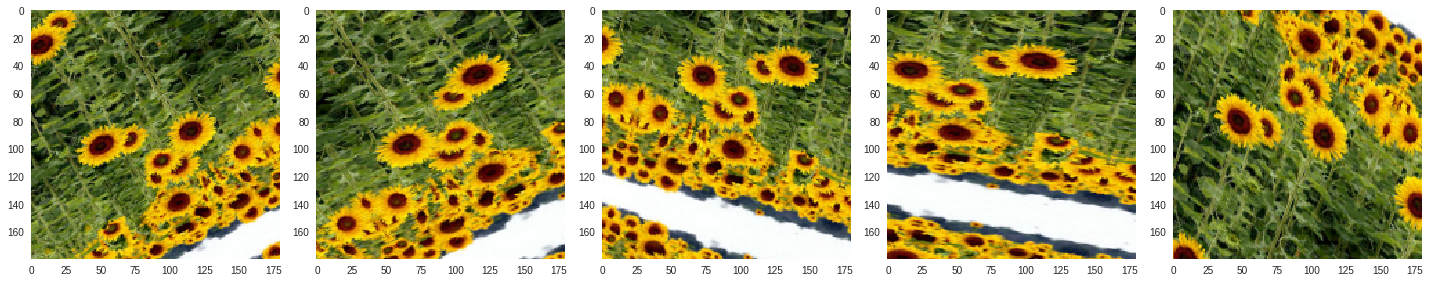

In [86]:
#show top 5 images
plotImages(augmented_images)

In [0]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

In [88]:
#define model
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dense(5, activation='softmax'))

model.summary()
conv_base.trainable=False

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                819264    
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 165       
Total params: 15,536,197
Trainable params: 15,536,197
Non-trainable params: 0
________________________________________________________________

In [0]:
#train the model using fit_generator

In [90]:
EPOCHS=50
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
32/32 [==============================] - 15s 464ms/step - loss: 1.4494 - acc: 0.3700 - val_loss: 1.0377 - val_acc: 0.6240
Epoch 2/50
32/32 [==============================] - 13s 407ms/step - loss: 1.0817 - acc: 0.5730 - val_loss: 0.8081 - val_acc: 0.7160
Epoch 3/50
32/32 [==============================] - 14s 425ms/step - loss: 0.9201 - acc: 0.6150 - val_loss: 0.7950 - val_acc: 0.7120
Epoch 4/50
32/32 [==============================] - 14s 425ms/step - loss: 0.8678 - acc: 0.6600 - val_loss: 0.7284 - val_acc: 0.7140
Epoch 5/50
32/32 [==============================] - 14s 426ms/step - loss: 0.8226 - acc: 0.6980 - val_loss: 0.7282 - val_acc: 0.7200
Epoch 6/50
32/32 [==============================] - 14s 425ms/step - loss: 0.7816 - acc: 0.6860 - val_loss: 0.6393 - val_acc: 0.7740
Epoch 7/50
32/32 [==============================] - 14s 429ms/step - loss: 0.7714 - acc: 0.6940 - val_loss: 0.6306 - val_acc: 0.7840
Epoch 8/50
32/32 [==============================] - 14s 427ms/step - 

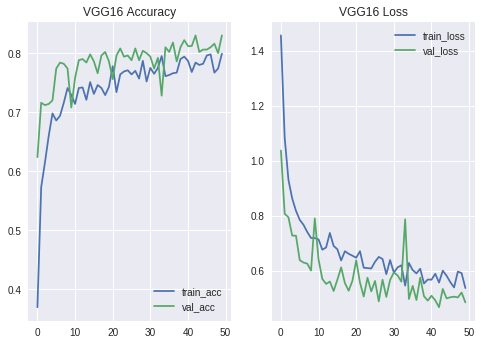

In [91]:
#plot acc
train_acc=history.history['acc']
val_acc=history.history['val_acc']
plt.subplot(1,2,1)
plt.plot(train_acc,label="train_acc")
plt.plot(val_acc,label="val_acc")
plt.legend()
plt.title('VGG16 Accuracy')

#plot loss
train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.subplot(1,2,2)
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.title('VGG16 Loss')
plt.show()

In [0]:
#Try Inception
conv_base2=InceptionV3(weights='imagenet',include_top=False,input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

In [97]:
#define model
model2 = Sequential()
model2.add(conv_base2)
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(64, activation=tf.nn.relu))
model2.add(Dense(32, activation=tf.nn.relu))
model2.add(Dense(5, activation='softmax'))

model2.summary()
conv_base2.trainable=False

model2.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 165       
Total params: 23,902,245
Trainable params: 2,099,461
Non-trainable params: 21,802,784
________________________________________________________

In [98]:
EPOCHS=60
history = model2.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/60
32/32 [==============================] - 20s 614ms/step - loss: 1.5382 - acc: 0.4180 - val_loss: 0.9312 - val_acc: 0.6420
Epoch 2/60
32/32 [==============================] - 11s 358ms/step - loss: 0.9608 - acc: 0.6560 - val_loss: 0.7481 - val_acc: 0.7500
Epoch 3/60
32/32 [==============================] - 13s 408ms/step - loss: 0.9808 - acc: 0.6670 - val_loss: 0.8274 - val_acc: 0.7240
Epoch 4/60
32/32 [==============================] - 13s 409ms/step - loss: 1.0236 - acc: 0.6330 - val_loss: 0.8192 - val_acc: 0.7200
Epoch 5/60
32/32 [==============================] - 13s 404ms/step - loss: 0.9142 - acc: 0.6830 - val_loss: 0.8243 - val_acc: 0.7080
Epoch 6/60
32/32 [==============================] - 13s 401ms/step - loss: 0.7696 - acc: 0.7350 - val_loss: 0.6034 - val_acc: 0.7900
Epoch 7/60
32/32 [==============================] - 13s 404ms/step - loss: 0.7481 - acc: 0.7280 - val_loss: 0.9903 - val_acc: 0.6900
Epoch 8/60
32/32 [==============================] - 13s 406ms/step - 

In [95]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

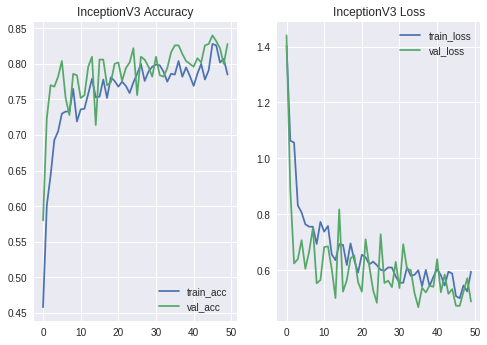

In [96]:
#plot acc
train_acc=history.history['acc']
val_acc=history.history['val_acc']
plt.subplot(1,2,1)
plt.plot(train_acc,label="train_acc")
plt.plot(val_acc,label="val_acc")
plt.legend()
plt.title('InceptionV3 Accuracy')

#plot loss
train_loss=history.history['loss']
val_loss=history.history['val_loss']
plt.subplot(1,2,2)
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()
plt.title('InceptionV3 Loss')
plt.show()

Include a short, informal write-up (using bullet points is fine). What differences do you see, and why? 


Differences:
With the exact same dropout rate, dense layer and optimizer, the model with Inception as the convolution base performs slightly better then the one with VGG16.


Reasons:
By taking a look into the dataset, we can see the images are somewhat diverse. The size and the location of flowers varies in the dataset. So the model that can extract feature in mutiple levels might be more suitable in this application. As when the flower is larger, it tends to prefer a larger kernel size.
VGG16 is more of a "update" of the AlexNet, at each layer it uses the 3X3 kernel. However in Inception V3, at each layer, there are 4 different kinds of kernel size (one of them is a stacked 3X3 kernel to mimic the 5X5 kernel while reduce the computation cost), it actually widen the network, and enables the network to extract multi-level features. 
So Inception is better at tackling diversed dataset. However since the dataset is not very large and only has 5 categories, the difference between two networks isn't that important, and the performance only has a subtle difference.  